In [1]:
# standard imports
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
#import pygmt
from pyproj import Proj, Geod
from osgeo import gdal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt


# user-defined imports
import tdcalc

# reload modules when changed
%reload_ext autoreload
%autoreload 2

**Note that the files have been shifted around after creation, proceed with a critical reading eye**

In [2]:
projfolder = '/Volumes/ProjectsGarlockCSAF/Garlock/Deformation/East/'

P = Proj('epsg:32611')
G = Geod(ellps='WGS84')

In [3]:
tracedf = pd.read_csv(projfolder[:-17]+'GIS/EastPoints.csv')
# Project to UTM
tracedf['x'], tracedf['y'] = P(tracedf.Lon, tracedf.Lat)


In [4]:
# Extend the points to depth
pts = []
# Add all surface points and edge points at depth,
# but skip every other so that 
# there are fewer triangles
for i in range(0,len(tracedf)):
    pts.append([tracedf.x.iloc[i], tracedf.y.iloc[i], 0])
# Edges
for i in [0,-1]:
    for d in range(1,6):
        pts.append([tracedf.x.iloc[i], tracedf.y.iloc[i], d*-1000])
# All other points
for i in np.arange(1,len(tracedf)-1,3):
    print(i)
    for d in range(1,6):
        pts.append([tracedf.x.iloc[i], tracedf.y.iloc[i], d*-1000])
tracedf.sort_values(by='x',inplace=True)
pts = np.array(pts)

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49


In [5]:
# Perform Delaunay triangulation
tri = Delaunay(pts[:, (0,2)])

# Create the triangulated surface
triangles = []
for indices in tri.simplices:
    triangles.append(pts[indices])

triangles = np.array(triangles)
print(triangles.shape) 


centroids = []

for triangle in triangles:
    # Calculate midpoints of each side
    midpoints = [(triangle[i] + triangle[(i + 1) % 3]) / 2 for i in range(3)]
    
    # Find centroid
    centroid = np.mean(midpoints, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)
print(centroids)

(212, 3, 3)
[[ 5.08787607e+05  3.94020910e+06 -6.66666667e+02]
 [ 5.08235897e+05  3.94032938e+06 -3.33333333e+02]
 [ 4.99585332e+05  3.93965860e+06 -3.33333333e+02]
 [ 5.08419933e+05  3.94030634e+06 -3.33333333e+02]
 [ 5.08593153e+05  3.94026122e+06 -3.33333333e+02]
 [ 5.09051915e+05  3.94013705e+06 -3.33333333e+02]
 [ 5.08952191e+05  3.94016830e+06 -3.33333333e+02]
 [ 5.07299595e+05  3.94038820e+06 -6.66666667e+02]
 [ 5.07986941e+05  3.94033134e+06 -6.66666667e+02]
 [ 4.98994640e+05  3.93972632e+06 -6.66666667e+02]
 [ 4.97973326e+05  3.93974476e+06 -6.66666667e+02]
 [ 5.01449532e+05  3.93975574e+06 -3.33333333e+02]
 [ 5.01143650e+05  3.93973312e+06 -6.66666667e+02]
 [ 5.00585898e+05  3.93969475e+06 -3.33333333e+02]
 [ 5.00123339e+05  3.93962036e+06 -3.33333333e+02]
 [ 5.00354618e+05  3.93965756e+06 -6.66666667e+02]
 [ 5.07458351e+05  3.94037284e+06 -3.33333333e+02]
 [ 5.07659495e+05  3.94035756e+06 -3.33333333e+02]
 [ 5.02878270e+05  3.93991812e+06 -3.33333333e+02]
 [ 5.01921108e+05  

In [6]:
len(tri.points[:,1][tri.points[:,1] == 0])

51

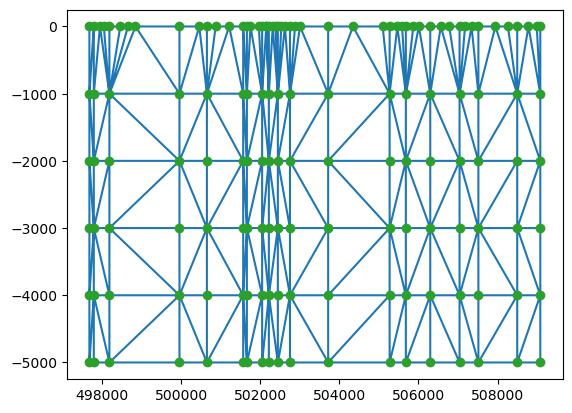

In [7]:
plt.triplot(tri.points[:,0], tri.points[:,1], tri.simplices)
plt.plot(tri.points[:,0], tri.points[:,1], 'o')
plt.show()

## Make slip

 Max a slip distribution with max slip at 4 km depth, pin surface end slip at 2 m above that point, and the other corners at 0

 Interpolate with an rbf from scipy: 

 'gaussian': exp(-(r/self.epsilon)**2)

 Where epsilon: "Adjustable constant for gaussian or multiquadrics functions - defaults to approximate average distance between nodes (which is a good start)."

In [8]:
max_slip_pt = pts[((pts[:,0]==pts[:,0].min())& (pts[:,2]==-5000))][0] 
surf_slip_pt = pts[(pts[:,0]==pts[:,0].min()) & (pts[:,2]==0)][0]
# Deepest, Northeast point
min_slip_pt = pts[(pts[:,0]==pts[:,0].max()) & (pts[:,2]==pts[:,2].max())][0]
max_slip_pt, surf_slip_pt, min_slip_pt, 

(array([ 497678.1761208 , 3939690.19444221,   -5000.        ]),
 array([ 497678.1761208 , 3939690.19444221,       0.        ]),
 array([ 509081.78566594, 3940125.72603039,       0.        ]))

In [9]:
import numpy as np
from scipy.interpolate import Rbf
# 
rbfi = Rbf([max_slip_pt[0],surf_slip_pt[0],min_slip_pt[0]], 
           [max_slip_pt[1],surf_slip_pt[1],min_slip_pt[1]], 
           [max_slip_pt[2],surf_slip_pt[2],min_slip_pt[2]], 
           [4,2,0],function='gaussian',epsilon=8000)  # radial basis function interpolator instance
di = rbfi(centroids[:,0], centroids[:,1], centroids[:,2])   # interpolated values
di.shape

(212,)

In [10]:
max(di), min(di)

(np.float64(3.9449908555145456), np.float64(0.02608320893358633))

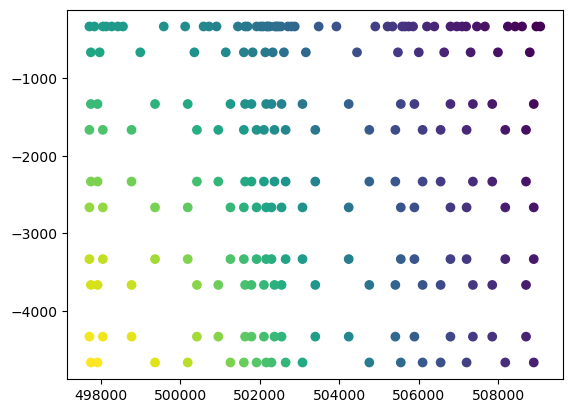

In [11]:
plt.scatter(centroids[:,0],centroids[:,2],c=di)


In [12]:
# Estimate Moment Magnitude
total_moment = 0
points = triangles
for i, simplex_indices in enumerate(tri.simplices):
    p1 = points[simplex_indices[0]]
    p2 = points[simplex_indices[1]]
    p3 = points[simplex_indices[2]]

    v1 = p2 - p1
    v2 = p3 - p1
    cross_product = np.cross(v1, v2)
    area = 0.5 * np.linalg.norm(cross_product)
    total_moment += area * 32e9 * 0.25 * di[i] 
    
print(f"Total Moment Magnitude: {2/3*np.log10(total_moment)-9.1}")

Total Moment Magnitude: 3.677095904264439


In [ ]:
# define an observation grid at surface
ulf = min(pts[:,0]), max(pts[:,1])+500
lrf = max(pts[:,0]), min(pts[:,1])-500
xsf = np.arange(ulf[0],lrf[0],0.5)
ysf = np.arange(lrf[1],ulf[1],0.5)
obs_gridfine = np.meshgrid(xsf,ysf)


ulc = min(pts[:,0]), pts[pts[:,0]==min(pts[:,0])][0,1]+5000
lrc = max(pts[:,0]), pts[pts[:,0]==max(pts[:,0])][0,1]-5000
xsc = np.arange(ulc[0],lrc[0],100)
ysc = np.arange(lrc[1],ulc[1],100)
obs_gridcoarse = np.meshgrid(xsc,ysc)



In [ ]:
obs_points = np.concatenate([np.column_stack([obs_gridcoarse[0].flatten(),obs_gridcoarse[1].flatten(),np.zeros(len(obs_gridcoarse[0].flatten()))]),
                           np.column_stack([obs_gridfine[0].flatten(),obs_gridfine[1].flatten(),np.zeros(len(obs_gridfine[0].flatten()))])])

In [ ]:
len(obs_points)

In [ ]:
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R2C1-016332977010_01_P001.tif /Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-016332977010_01_P001.tif /Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-merged.tif
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R2C1-016332977010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R3C1-016332977010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R4C1-016332977010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/23SEP05214655-P1BS_R3C1-merged.tif
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2023GarlockEastDEM.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2023GarlockEastDEM-cropped.tif

#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2020GarlockEastDEM.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/dems/2020GarlockEastDEM-cropped.tif
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214017-P1BS_R2C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214017-P1BS_R3C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214017-P1BS_R3C1-merged.tif 
#!gdalwarp -overwrite -srcnodata 0 -r near -tr  0.5  0.5 -te 497678.1761208036 3935125.726030385 509081.78566594014 3944690.1944422117 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214111-P1BS_R2C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214111-P1BS_R3C1-016332976010_01_P001.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/metashape/EastProducts/orthophotos/20APR28214111-P1BS_R3C1-merged.tif

In [ ]:
im = gdal.Open('/Users/chanagan/Desktop/DGStereo/Garlock/metashape/EastProducts/orthophotos/23SEP05214604-P1BS_R3C1-merged.tif')


In [ ]:
gt = im.GetGeoTransform()
bounds = tt.getOutputBounds(im)

In [ ]:
DONT RUN unless you need to do-over!! Takes forever,
#generate half-space displacements and strains at two points
obs=obs_points

# initiate
i=0
tri = triangles[i]
ss = [di[i]]
ds = np.zeros(len(ss))
op = np.zeros(len(ss))
slip=[ss,ds,op]
nu=0.25
displ = tdcalc.TDdispHS(obs,tri,slip,nu)

for i in range(1,len(triangles)):
    print(i)
    tri = triangles[i]
    ss = [di[i]]
    ds = np.zeros(len(ss))
    op = np.zeros(len(ss))
    slip=[ss,ds,op]
    displ += tdcalc.TDdispHS(obs,tri,slip,nu)

print('displ',displ, np.shape(displ))
df = pd.DataFrame(np.column_stack([obs,displ]),columns=['x','y','z','dx','dy','dz'])
df.to_csv('bigdispl.txt')


## Interpolate deformation field and deform the rasters

In [3]:
import pandas as pd
import numpy as np
from osgeo import gdal
import rioxarray
#import pygmt
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

In [2]:
df = pd.read_csv('bigdispl.txt',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'bigdispl.txt'

In [4]:
im = rioxarray.open_rasterio('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged.tif')
gdalim = gdal.Open('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged.tif')
imgrid = np.meshgrid(im.x.data,im.y.data)

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
bounds = tt.getOutputBounds(gdalim)
proj = im.spatial_ref.crs_wkt

In [ ]:
Dont rerun
gridX = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dx.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridXinterp = gridX.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridXinterp.rio.to_raster(projfolder+'Deformation/EastdX-rio.tif',spatial_ref=proj,driver='Gtiff')


In [ ]:
Dont rerun
gridY = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dy.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridYinterp = gridY.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridYinterp.rio.to_raster(projfolder+'Deformation/EastdY-rio.tif',spatial_ref=proj)


In [ ]:
Dont rerun
gridZ = pygmt.xyz2grd(x=df.x.values,y=df.y.values,z=df.dz.values,
                      spacing=[0.5],
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
gridZinterp = gridZ.interpolate_na(dim='x',method='slinear').interpolate_na(dim='y',method='slinear')
gridZinterp.rio.to_raster(projfolder+'Deformation/EastdZ-rio.tif',spatial_ref=proj)


In [24]:
Dont rerun
# Make z deformation larger
imz = rioxarray.open_rasterio('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdZ-rio.tif')
imz = imz*4
imz.rio.to_raster('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4.tif',spatial_ref='EPSG:32611')



In [22]:
#!gdal_edit.py -a_srs EPSG:32611 /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdZ-rio.tif
#!gdal_edit.py -a_srs EPSG:32611 /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdX-rio.tif
#!gdal_edit.py -a_srs EPSG:32611 /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdY-rio.tif

In [6]:
projfolder = '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/'

In [7]:
imx = rioxarray.open_rasterio(projfolder+'EastdX-rio.tif')
imy = rioxarray.open_rasterio(projfolder+'EastdY-rio.tif')
imz = rioxarray.open_rasterio(projfolder+'EastdZ-rio-x4.tif')
#imelev = rioxarray.open_rasterio(projfolder+'metashape/EastProducts/dems/2023GarlockEastDEM-cropped.tif)
imgrid = np.meshgrid(imx.x,imx.y)

In [8]:
# y coords are flipped about the x-axis from the orthophoto coords
dx = imx.data[0]
dy = imy.data[0]
dz = imz.data[0] 

In [9]:
# Sample points at deformed locations
newx = imgrid[0]-dx
newy = imgrid[1]-dy
new_points = np.column_stack([newx.flatten(),newy.flatten()])
old_points = np.column_stack([imgrid[0].flatten(),imgrid[1].flatten()])

# Identify rows containing NaN entries
nan_indices = np.isnan(new_points).any(axis=1)

# Drop rows with NaN entries
points_without_nan = new_points[~nan_indices]
old_points_without_nan = old_points[~nan_indices]

In [ ]:
# see interpolation; Default uses “natural” conditions (second partial derivative normal to edge is zero) unless the grid is automatically recognized as periodic.
deformed1 = pygmt.grdtrack(projfolder+'micmac/23SEP05214604-P1BS_R3C1-merged.tif',
                          points=points_without_nan,no_skip=True)
deformed2 = pygmt.grdtrack(projfolder+'micmac/23SEP05214655-P1BS_R3C1-merged.tif',
                          points=points_without_nan,no_skip=True)
# DEM
deformedDEM = pygmt.grdtrack(projfolder+'micmac/2023GarlockEastDEM-cropped.tif',
                          points=points_without_nan,no_skip=True)

In [ ]:
deformed1.columns = ['x','y','vals']
deformed2.columns = ['x','y','vals']
deformedDEM.columns = ['x','y','vals']

In [ ]:
deformed1['oldx'] = old_points_without_nan[:,0]
deformed1['oldy'] = old_points_without_nan[:,1]
deformed2['oldx'] = old_points_without_nan[:,0]
deformed2['oldy'] = old_points_without_nan[:,1]
deformedDEM['oldx'] = old_points_without_nan[:,0]
deformedDEM['oldy'] = old_points_without_nan[:,1]

In [ ]:
deformed1Grid = pygmt.xyz2grd(x=deformed1.oldx.values,y=deformed1.oldy.values,z=deformed1.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformed2Grid = pygmt.xyz2grd(x=deformed2.oldx.values,y=deformed2.oldy.values,z=deformed2.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformedDEMGrid = pygmt.xyz2grd(x=deformedDEM.oldx.values,y=deformedDEM.oldy.values,z=deformedDEM.vals.values,
                      spacing='0.5/0.5',
                      region=[bounds[0],bounds[2],bounds[3],bounds[1]])
deformedDEMGrid += dz # add in vertcal def

In [11]:
import pygmt

In [ ]:
deformed1Grid.rio.to_raster(projfolder+'Deformation/2023deformed04ortho-rio.tif',spatial_ref=proj)
deformed2Grid.rio.to_raster(projfolder+'Deformation/2023deformed55ortho-rio.tif',spatial_ref=proj)
deformedDEMGrid.rio.to_raster(projfolder+'Deformation/2023deformedDEM-rio.tif',spatial_ref=proj)

In [26]:
# Change data type
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214017-P1BS_R3C1-merged.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214017-P1BS_R3C1-merged-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214111-P1BS_R3C1-merged.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/20APR28214111-P1BS_R3C1-merged-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed04ortho-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed04ortho-rio-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed55ortho-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformed55ortho-rio-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped.tif  /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif 
!gdalwarp -overwrite -r near -ot Float32 -of GTiff -s_srs EPSG:32611 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif
#!gdalwarp -overwrite -r near -ot Float32 -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/23SEP05214604-P1BS_R3C1-merged-f32.tif 




python(72801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Creating output file that is 22808P x 19130L.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


# MicMac Post Processing

In [14]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pygmt
#from pyproj import Proj, Geod
from osgeo import gdal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2


In [15]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

In [16]:
predem = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif'

In [ ]:
Don't Rerun unless necessary
# EW, NS, Correl file creation, and Parallel and Perpendicular
for fold in ['defaultsMEC1','defaultsMEC2','defaultsMEC3','defaultsMEC4','defaultsMECtest','defaultsMECdem']:
    tt.micmacPostProcessing(folder=folder+fold+'/',
                         prefile=predem,
                         outprefix=folder+fold+'/')
    
    #par, perp = tt.projectDisp(folder+fold+'/'+'EWmicmac.tif',folder+fold+'/'+'NSmicmac.tif',268,mask=None,partif=folder+fold+'/'+'ParallelDisp.tif',perptif=folder+fold+'/'+'PerpendicularDisp.tif')

In [ ]:
infolderlist = []
for fold in ['defaultsMEC1/','defaultsMEC2/','defaultsMEC3/','defaultsMEC4/']:
    infolderlist.append(folder+fold)
print(infolderlist)

In [ ]:
Don't Rerun unless necessary
# Stack the displacement maps based on correlation score
tt.micmacStack(infolderlist,folder)

In [5]:
Don't Rerun unless necessary
# Create vertical displacement map from the stacked horizontal results
dem1file = predem
dem2file = folder+'2023deformedDEM-rio-f32.tif'
nsfile = folder+'NSDispStacked.tif'
ewfile = folder+'EWDispStacked.tif'

#tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf='VerticalDisp.tif')


SyntaxError: unterminated string literal (detected at line 1) (2709610747.py, line 1)

In [ ]:
Don't Rerun unless necessary
# 4 Vertical maps, instead of one from stacked displacements
dem1file = predem
dem2file = folder+'2023deformedDEM-rio-f32.tif'
for fold in ['defaultsMEC1','defaultsMEC2','defaultsMEC3','defaultsMEC4','defaultsMECtest','defaultsMECdem']:
    nsfile = folder+fold+'/NSmicmac.tif'
    ewfile = folder+fold+'/EWmicmac.tif'
    tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf=folder+fold+'/UDmicmac.tif')

In [ ]:
Don't Rerun unless necessary
# One stacked Vertical map
tt.micmacStackUD(infolderlist,folder)

In [2]:
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/EWDispStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/NSDispStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/UDDispStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/UDDispStackedEPSG4326.tif

!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Volumes/ProjectsGarlockCSAF/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmac.tif /Volumes/ProjectsGarlockCSAF/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmacEPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32EPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32EPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdX-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdX-rioEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349 -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdY-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdY-rioEPSG4326.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdZ-rio.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdZ-rioEPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4EPSG4326.tif

#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.0256160 35.559928 -116.899990 35.6439349  -r near -of GTiff /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/CorrelStacked.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/CorrelStackedEPSG4326.tif



Creating output file that is 25061P x 16759L.
Using internal nodata values (e.g. 0) for image /Volumes/ProjectsGarlockCSAF/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmac.tif.
Copying nodata values from source /Volumes/ProjectsGarlockCSAF/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmac.tif to destination /Volumes/ProjectsGarlockCSAF/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmacEPSG4326.tif.
Processing /Volumes/ProjectsGarlockCSAF/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmac.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


# Denoise and filter

In [2]:
from skimage.restoration import denoise_nl_means, estimate_sigma
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pygmt
#from pyproj import Proj, Geod
from osgeo import gdal
from skimage.restoration import denoise_bilateral

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2


In [3]:
import numpy as np
from scipy import signal

def apply_edge_window_2d(chunk, window_type='hann', edge_ratio=0.1):
    """
    Apply a window function to the edges of a 2D chunk to reduce edge effects.
    """
    rows, cols = chunk.shape
    window_rows = int(rows * edge_ratio)
    window_cols = int(cols * edge_ratio)

    if window_type == 'hann':
        window_row = np.hanning(2 * window_rows)
        window_col = np.hanning(2 * window_cols)
    elif window_type == 'hamming':
        window_row = np.hamming(2 * window_rows)
        window_col = np.hamming(2 * window_cols)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_row = np.concatenate([window_row[:window_rows], np.ones(rows - 2 * window_rows), window_row[window_rows:]])
    window_col = np.concatenate([window_col[:window_cols], np.ones(cols - 2 * window_cols), window_col[window_cols:]])

    window_2d = np.outer(window_row, window_col)
    windowed_chunk = chunk * window_2d

    return windowed_chunk

def create_filter(filter_type, cutoff_low, cutoff_high):
    """
    Create a Butterworth filter based on the specified type and cutoff frequencies.
    """
    if filter_type == 'high':
        b, a = signal.butter(4, cutoff_high, btype='high')
    elif filter_type == 'low':
        b, a = signal.butter(4, cutoff_low, btype='low')
    elif filter_type == 'band':
        b, a = signal.butter(4, [cutoff_low, cutoff_high], btype='band')
    else:
        raise ValueError(f"Unsupported filter type: {filter_type}")
    return b, a

def process_image(image, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type='band', col_cutoff_low=0.001, col_cutoff_high=0.1,
                  stripw=1000, window_type='hann', edge_ratio=0.1):
    """
    Process the image to remove satellite stripes and waves while preserving
    long-wavelength fault deformation and near-fault offsets.
    
    Parameters:
        image (np.array): 2D image array.
        row_filter_type (str): Type of filter to apply on rows ('high', 'low', 'band').
        row_cutoff_low (float): Low cutoff frequency for row filtering.
        row_cutoff_high (float): High cutoff frequency for row filtering.
        col_filter_type (str): Type of filter to apply on columns ('high', 'low', 'band').
        col_cutoff_low (float): Low cutoff frequency for column filtering.
        col_cutoff_high (float): High cutoff frequency for column filtering.
        stripw (int): Width of strips for processing.
        window_type (str): Type of window function to apply ('hann', 'hamming').
        edge_ratio (float): Fraction of the strip edges to apply windowing.
    
    Returns:
        np.array: Filtered image.
    """
    # Create the filters for rows and columns
    if row_filter_type is not None:
        b_row, a_row = create_filter(row_filter_type, row_cutoff_low, row_cutoff_high)
    if col_filter_type is not None:
        b_col, a_col = create_filter(col_filter_type, col_cutoff_low, col_cutoff_high)

    # NAN mask
    mask = ((np.abs(image) > 10) & (np.isnan(image)))
    image[mask] = 0

    # Initialize arrays to store filtered results
    chunk_filtered_col = np.zeros_like(image)
    chunk_filtered_row = np.zeros_like(image)
    
    if row_filter_type is not None:
        # Process the image in chunks of stripw rows at a time
        for start_row in range(0, image.shape[0], int(stripw/4)): # shifting by half of the strip width
            end_row = min(start_row + stripw, image.shape[0])
            chunk = image[start_row:end_row, :]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk, window_type, edge_ratio)

            # Sum along columns for this chunk
            signal_row = np.sum(chunk, axis=0)
            

            # Apply the chosen filter to remove stripes/waves
            filter_row = signal.filtfilt(b_row, a_row, signal_row)

            # Subtract the filtered signal from each row in the chunk
            chunk_filtered_row[start_row:end_row, :] = filter_row[np.newaxis, :] / (end_row - start_row)

    if col_filter_type is not None:
        # Process the image in chunks of stripw columns at a time
        for start_col in range(0, image.shape[1], int(stripw/4)):
            end_col = min(start_col + stripw, image.shape[1])
            chunk = image[:, start_col:end_col]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk.T, window_type, edge_ratio).T

            # Sum along rows for this chunk
            signal_col = np.sum(chunk, axis=1)
            signal_col[np.isnan(signal_col)] = 0

            # Apply the chosen filter to remove stripes/waves
            filter_col = signal.filtfilt(b_col, a_col, signal_col)

            # Subtract the filtered signal from each column in the chunk
            chunk_filtered_col[:, start_col:end_col] = filter_col[:, np.newaxis] / (end_col - start_col)

    # Combine the results to get the final filtered image
    filtered_image = image - chunk_filtered_row - chunk_filtered_col

    # Handle any remaining NANs or zeros
    filtered_image[mask] = np.nan

    return filtered_image

In [4]:
folder = '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/'


In [ ]:
inlist2 = [folder+'EWDispStackedEPSG4326.tif',
    folder+'NSDispStackedEPSG4326.tif']
    #folder+'UDDispStackedEPSG4326.tif']
inlist2 = [folder+'defaultsMECdem/EWmicmacEPSG4326.tif',
    folder+'defaultsMECdem/NSmicmacEPSG4326.tif']
    #folder+'UDDispStackedEPSG4326.tif']

for file in inlist2[-1:]:
    im = gdal.Open(file)
    imdata = im.GetRasterBand(1).ReadAsArray()
    imdata[np.isnan(imdata)] = 0
    
    denoise = denoise_bilateral(imdata, sigma_color=None, sigma_spatial=8, bins=10000, mode='edge')

    print('Bandpass filtering')
    filtered = process_image(denoise, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                      col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                      stripw=1000, window_type='hann', edge_ratio=0.1)
    
    #tt.save_geotiff(filtered,f'/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/{file[-20:-4]}_bidenoise_filtered.tif',im.GetGeoTransform(),im.GetProjection())


Bandpass filtering


In [20]:
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG32611_bidenoise_filtered.tif
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG32611_bidenoise_filtered.tif
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/EWmicmacEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/EWmicmacEPSG32611_bidenoise_filtered.tif
#!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG4326_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG32611_bidenoise_filtered.tif

!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32a.tif
!gdalwarp -t_srs EPSG:32611 -overwrite -te 497678.532 3935139.907 509063.532 3944461.407 -tr 0.5 -0.5 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32a.tif


Creating output file that is 22770P x 18643L.
Using internal nodata values (e.g. 0) for image /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32a.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 22770P x 18643L.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
im = gdal.Open('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG32611_bidenoise_filtered.tif')
bounds = tt.getOutputBounds(im)
print(np.round(bounds[0],3),np.round(bounds[3],3),np.round(bounds[2],3),np.round(bounds[1],3),sep=' ')

497678.532 3935139.907 509063.532 3944461.407


Creating output file that is 25188P x 16844L.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
# Recreate Vert map from filt result
# Create vertical displacement map from the stacked horizontal results
dem1file = folder+'2020GarlockEastDEM-cropped-f32a.tif'
dem2file = folder+'2023deformedDEM-rio-f32a.tif'
nsfile = folder+'defaultsMECdem/NSmicmacEPSG32611_bidenoise_filtered.tif'
ewfile = folder+'defaultsMECdem/EWmicmacEPSG32611_bidenoise_filtered.tif'


tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf=folder+'defaultsMECdem/UDmicmacEPSG32611_bidenoise_filtered.tif')
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmacEPSG32611_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif


array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       ...,
       [-5.9960938e-01, -6.4569092e-01, -6.4538574e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-5.8514404e-01, -6.8115234e-01, -6.8353271e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-5.5346680e-01, -6.5698242e-01, -6.8164062e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [19]:
# Recreate Vert map from filt result
# Create vertical displacement map from the stacked horizontal results
dem1file = folder+'2020GarlockEastDEM-cropped-f32.tif'
dem2file = folder+'2023deformedDEM-rio-f32.tif'
nsfile = folder+'NSDispStackedEPSG32611_bidenoise_filtered.tif'
ewfile = folder+'EWDispStackedEPSG32611_bidenoise_filtered.tif'


tt.verticalDisp(dem1file,dem2file,nsfile,ewfile,outf=folder+'UDfromHDispStackedEPSG32611_bidenoise_filtered.tif')
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered.tif


ValueError: operands could not be broadcast together with shapes (18643,22770) (19129,22807) 

In [9]:
inlist2 = [folder+'defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif',
           folder+'UDfromHDispStackedEPSG4326_bidenoise_filtered.tif']

for file in inlist2[:-1]:
    im = gdal.Open(file)
    # Create a copy of the raster in memory or save to a new file
    driver = gdal.GetDriverByName("MEM")  # Use "GTiff" to save to disk instead
    im_copy = driver.CreateCopy("", im, 0)  # "" for in-memory, or provide a file name

    # Get the band from the copy and fill NoData values
    band = im_copy.GetRasterBand(1)
    gdal.FillNodata(targetBand=band, maskBand=None, maxSearchDist=10000, smoothingIterations=0)

    # Access the modified array without saving
    filled_array = band.ReadAsArray()
    
    denoise = denoise_bilateral(filled_array, sigma_color=None, sigma_spatial=8, bins=10000, mode='edge')

    print('Bandpass filtering')
    filtered = process_image(denoise, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                      col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                      stripw=1000, window_type='hann', edge_ratio=0.1)
   #if 'dem' in file:
    #    tt.save_geotiff(filtered,folder+'defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif',im.GetGeoTransform(),im.GetProjection())
    #else:
    #    tt.save_geotiff(filtered,folder+'UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif',im.GetGeoTransform(),im.GetProjection())


Bandpass filtering


In [4]:
inlist2 = ['defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif',
           'UDfromHDispStackedEPSG4326_bidenoise_filtered.tif']

for file in inlist2[:-1]:
    print(file)

defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif


In [5]:
im = gdal.Open('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326_bidenoise_filtered.tif')
bounds = tt.getOutputBounds(im)
print(bounds[0],bounds[3],bounds[2],bounds[1],sep=' ')

-117.025616 35.559928 -116.89999 35.6439349


In [1]:
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG32611_bidenoise_filtered_refiltered.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered_refiltered.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG32611_bidenoise_filtered_refiltered.tif  /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif
#!gdalwarp -t_srs EPSG:4326 -overwrite -te -117.025616 35.559928 -116.89999 35.6439349  -tr 4.987476808905901e-06 -4.987418543131882e-06 -srcnodata -9999 -r bilinear -of GTiff -ot Float32 /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif /Volumes/Extreme\ Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326-clipped.tif

Creating output file that is 25188P x 16844L.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326-clipped.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Creating output file that is 21560P x 15499L.
Copying nodata values from source /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG32611_bidenoise_filtered_refiltered.tif to destination /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif.
Processing /Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG32611_bidenoise_filtered_refiltered.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


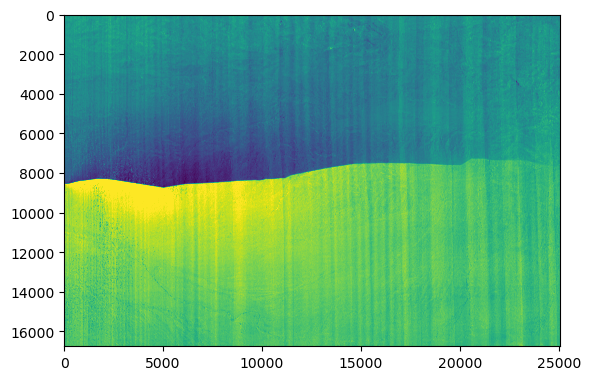

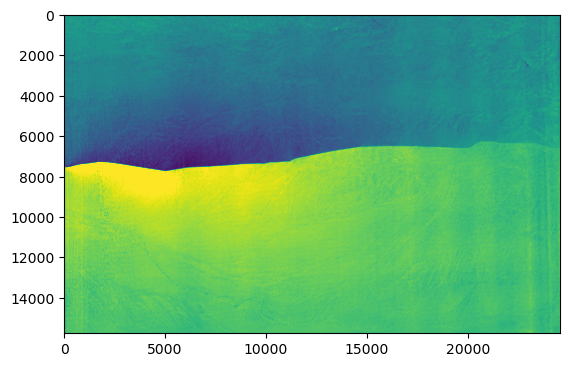

In [59]:
plt.imshow(imdata,vmin=-1,vmax=1)
plt.show()
plt.imshow(filtered,vmin=-1,vmax=1)

In [55]:
denoise[15750:16000,:]

array([[0.54504341, 0.54449081, 0.5441219 , ..., 0.16364394, 0.15658738,
        0.14900063],
       [0.54183741, 0.5409682 , 0.540294  , ..., 0.16425646, 0.15708895,
        0.14939457],
       [0.53889285, 0.53773858, 0.53677039, ..., 0.16488115, 0.15759288,
        0.14978041],
       ...,
       [0.50353314, 0.50250463, 0.50153108, ..., 0.1657265 , 0.15872238,
        0.15122852],
       [0.50537188, 0.5043455 , 0.50337131, ..., 0.16702726, 0.15994915,
        0.15237247],
       [0.50725701, 0.50623862, 0.50526488, ..., 0.16819004, 0.16104778,
        0.15340072]])

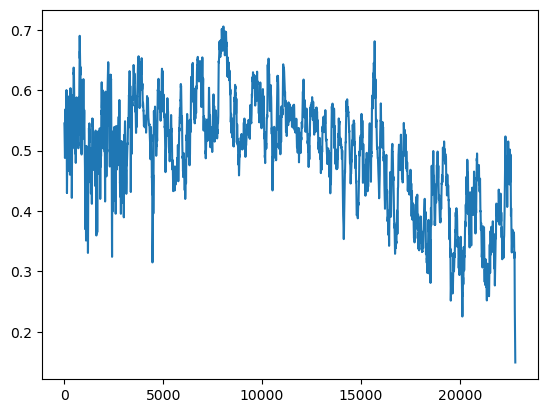

In [48]:
#plt.plot(filtered[15750,:])
plt.plot(denoise[15750,:])

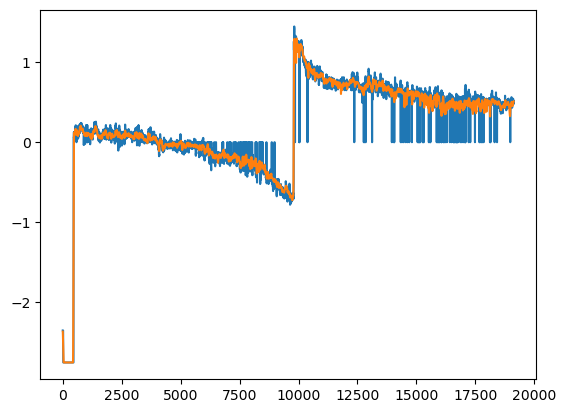

In [16]:
plt.plot(imdata[:,1000])
plt.plot(denoise[:,1000])

In [6]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'


In [14]:
tt.save_geotiff(denoise2_fast,file[:-17]+f'{file[-17:-4]}_filtered.tif',im.GetGeoTransform(),im.GetProjection())


In [16]:
# NL means then destriping
noisy = im2data

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy))
print(f'estimated noise standard deviation = {sigma_est}')

# Note that increasing the nl_means patch size parameters increases run-time
patch_kw = dict(
    patch_size=100, patch_distance=12  # patch size (patch_size x patch_size) and search area (patchdistance+patchdistance+1)**2
)
print('Running NL means')
# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(
    noisy, h=0.7 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
)



estimated noise standard deviation = 0.00026825528863995
Running NL means


In [20]:
from skimage.restoration import denoise_bilateral
from skimage.filters import window, difference_of_gaussians

In [41]:
denoise2_fast = denoise_bilateral(im2data, sigma_color=None, sigma_spatial=8, bins=10000, mode='edge')

Bandpass filtering


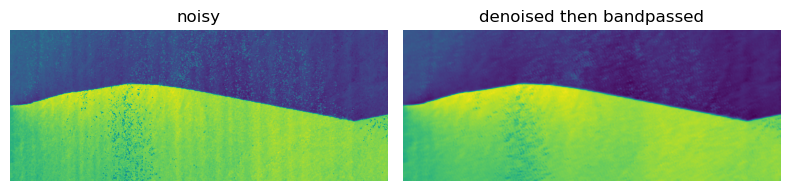

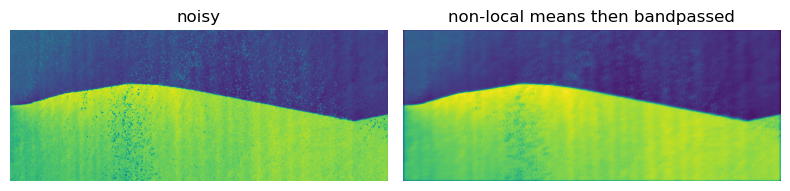

In [36]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharex=True, sharey=True)

ax[0].imshow(im2data)
ax[0].axis('off')
ax[0].set_title('noisy')
ax[1].imshow(denoise2_fast)
ax[1].axis('off')
ax[1].set_title('non-local means then bandpassed')

fig.tight_layout()

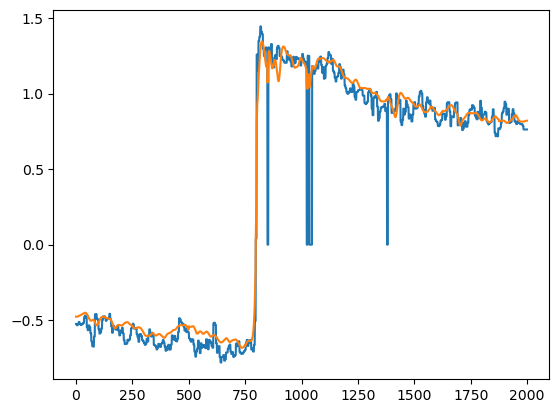

In [49]:
plt.plot(im2data[:,1000])
plt.plot(nl_filtered[:,1000])

## Filter

In [ ]:
from sklearn.decomposition import FastICA, PCA, IncrementalPCA
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2


folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

from pyproj import Proj, Geod
P = Proj('epsg:32611')
G = Geod(ellps='WGS84')


In [ ]:
im1 = gdal.Open(folder+'NSDispStacked.tif')
im1data = im1.GetRasterBand(1).ReadAsArray()#[500:,:]
im2 = gdal.Open(folder+'EWDispStacked.tif')
im2data = im2.GetRasterBand(1).ReadAsArray()#[500:,:]
im3 = gdal.Open(folder+'UDDispStacked.tif')
im3data = im3.GetRasterBand(1).ReadAsArray()#[500:,:]


In [ ]:
gt = im1.GetGeoTransform()
res = gt[1]
refimNodata = im1.GetRasterBand(1).GetNoDataValue()

In [26]:
import numpy as np
from scipy import signal

def apply_edge_window_2d(chunk, window_type='hann', edge_ratio=0.1):
    """
    Apply a window function to the edges of a 2D chunk to reduce edge effects.
    """
    rows, cols = chunk.shape
    window_rows = int(rows * edge_ratio)
    window_cols = int(cols * edge_ratio)

    if window_type == 'hann':
        window_row = np.hanning(2 * window_rows)
        window_col = np.hanning(2 * window_cols)
    elif window_type == 'hamming':
        window_row = np.hamming(2 * window_rows)
        window_col = np.hamming(2 * window_cols)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_row = np.concatenate([window_row[:window_rows], np.ones(rows - 2 * window_rows), window_row[window_rows:]])
    window_col = np.concatenate([window_col[:window_cols], np.ones(cols - 2 * window_cols), window_col[window_cols:]])

    window_2d = np.outer(window_row, window_col)
    windowed_chunk = chunk * window_2d

    return windowed_chunk

def create_filter(filter_type, cutoff_low, cutoff_high):
    """
    Create a Butterworth filter based on the specified type and cutoff frequencies.
    """
    if filter_type == 'high':
        b, a = signal.butter(4, cutoff_high, btype='high')
    elif filter_type == 'low':
        b, a = signal.butter(4, cutoff_low, btype='low')
    elif filter_type == 'band':
        b, a = signal.butter(4, [cutoff_low, cutoff_high], btype='band')
    else:
        raise ValueError(f"Unsupported filter type: {filter_type}")
    return b, a

def process_image(image, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type='band', col_cutoff_low=0.001, col_cutoff_high=0.1,
                  stripw=1000, window_type='hann', edge_ratio=0.1):
    """
    Process the image to remove satellite stripes and waves while preserving
    long-wavelength fault deformation and near-fault offsets.
    
    Parameters:
        image (np.array): 2D image array.
        row_filter_type (str): Type of filter to apply on rows ('high', 'low', 'band').
        row_cutoff_low (float): Low cutoff frequency for row filtering.
        row_cutoff_high (float): High cutoff frequency for row filtering.
        col_filter_type (str): Type of filter to apply on columns ('high', 'low', 'band').
        col_cutoff_low (float): Low cutoff frequency for column filtering.
        col_cutoff_high (float): High cutoff frequency for column filtering.
        stripw (int): Width of strips for processing.
        window_type (str): Type of window function to apply ('hann', 'hamming').
        edge_ratio (float): Fraction of the strip edges to apply windowing.
    
    Returns:
        np.array: Filtered image.
    """
    # Create the filters for rows and columns
    if row_filter_type is not None:
        b_row, a_row = create_filter(row_filter_type, row_cutoff_low, row_cutoff_high)
    if col_filter_type is not None:
        b_col, a_col = create_filter(col_filter_type, col_cutoff_low, col_cutoff_high)

    # NAN mask
    mask = ((np.abs(image) > 10) & (np.isnan(image)))
    image[mask] = 0

    # Initialize arrays to store filtered results
    chunk_filtered_col = np.zeros_like(image)
    chunk_filtered_row = np.zeros_like(image)
    
    if row_filter_type is not None:
        # Process the image in chunks of stripw rows at a time
        for start_row in range(0, image.shape[0], int(stripw/4)): # shifting by half of the strip width
            end_row = min(start_row + stripw, image.shape[0])
            chunk = image[start_row:end_row, :]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk, window_type, edge_ratio)

            # Sum along columns for this chunk
            signal_row = np.sum(chunk, axis=0)
            

            # Apply the chosen filter to remove stripes/waves
            filter_row = signal.filtfilt(b_row, a_row, signal_row)

            # Subtract the filtered signal from each row in the chunk
            chunk_filtered_row[start_row:end_row, :] = filter_row[np.newaxis, :] / (end_row - start_row)

    if col_filter_type is not None:
        # Process the image in chunks of stripw columns at a time
        for start_col in range(0, image.shape[1], int(stripw/4)):
            end_col = min(start_col + stripw, image.shape[1])
            chunk = image[:, start_col:end_col]

            # Apply windowing to the chunk to reduce edge effects
            chunk = apply_edge_window_2d(chunk.T, window_type, edge_ratio).T

            # Sum along rows for this chunk
            signal_col = np.sum(chunk, axis=1)
            signal_col[np.isnan(signal_col)] = 0

            # Apply the chosen filter to remove stripes/waves
            filter_col = signal.filtfilt(b_col, a_col, signal_col)

            # Subtract the filtered signal from each column in the chunk
            chunk_filtered_col[:, start_col:end_col] = filter_col[:, np.newaxis] / (end_col - start_col)

    # Combine the results to get the final filtered image
    filtered_image = image - chunk_filtered_row - chunk_filtered_col

    # Handle any remaining NANs or zeros
    filtered_image[mask] = np.nan

    return filtered_image

In [ ]:
inlist = [folder+'defaultsMEC1/NSmicmac.tif',
    folder+'defaultsMEC3/NSmicmac.tif',
    folder+'defaultsMEC2/NSmicmac.tif',
    folder+'defaultsMEC4/NSmicmac.tif',
    folder+'defaultsMEC1/EWmicmac.tif',
    folder+'defaultsMEC3/EWmicmac.tif',
    folder+'defaultsMEC2/EWmicmac.tif',
    folder+'defaultsMEC4/EWmicmac.tif',
    folder+'defaultsMEC1/UDmicmac.tif',
    folder+'defaultsMEC3/UDmicmac.tif',
    folder+'defaultsMEC2/UDmicmac.tif',
    folder+'defaultsMEC4/UDmicmac.tif']

inlist2 = [folder+'EWDispStacked.tif',
    folder+'NSDispStacked.tif',
    folder+'UDDispStacked.tif']

In [ ]:
#Don't rerun unless necessary
## Filter all images
#for file in inlist:
#    im = gdal.Open(file)
#    imdata = im.GetRasterBand(1).ReadAsArray()
#    filtered = process_image(imdata, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
#                  col_filter_type='high', col_cutoff_low=0.001, col_cutoff_high=0.01,
#                  stripw=1000, window_type='hann', edge_ratio=0.1)
#    
#    # Save Files
#    tt.save_geotiff(filtered,file[:-12]+f'{file[-12:-4]}_filtered.tif',im.GetGeoTransform(),im.GetProjection())

for file in [inlist2[0]]:
    im = gdal.Open(file)
    imdata = im.GetRasterBand(1).ReadAsArray()
    filtered = process_image(imdata, row_filter_type='band', row_cutoff_low=0.001, row_cutoff_high=0.1,
                  col_filter_type=None, col_cutoff_low=0.001, col_cutoff_high=0.01,
                  stripw=1000, window_type='hann', edge_ratio=0.1)
    tt.save_geotiff(filtered,file[:-17]+f'{file[-17:-4]}_filtered2.tif',im.GetGeoTransform(),im.GetProjection())



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise


astro = img_as_float(data.astronaut())
astro = astro[30:180, 150:300,0]

sigma = 0.08
noisy = random_noise(astro, var=sigma**2)

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(
    patch_size=5, patch_distance=6, channel_axis=-1  # 5x5 patches  # 13x13 search area
)

# slow algorithm
denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False, **patch_kw)

# slow algorithm, sigma provided
denoise2 = denoise_nl_means(
    noisy, h=0.8 * sigma_est, sigma=sigma_est, fast_mode=False, **patch_kw
)

# fast algorithm
denoise_fast = denoise_nl_means(noisy, h=0.8 * sigma_est, fast_mode=True, **patch_kw)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(
    noisy, h=0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw
)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6), sharex=True, sharey=True)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')
ax[0, 1].imshow(denoise)
ax[0, 1].axis('off')
ax[0, 1].set_title('non-local means\n(slow)')
ax[0, 2].imshow(denoise2)
ax[0, 2].axis('off')
ax[0, 2].set_title('non-local means\n(slow, using $\\sigma_{est}$)')
ax[1, 0].imshow(astro)
ax[1, 0].axis('off')
ax[1, 0].set_title('original\n(noise free)')
ax[1, 1].imshow(denoise_fast)
ax[1, 1].axis('off')
ax[1, 1].set_title('non-local means\n(fast)')
ax[1, 2].imshow(denoise2_fast)
ax[1, 2].axis('off')
ax[1, 2].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

fig.tight_layout()

# print PSNR metric for each case
psnr_noisy = peak_signal_noise_ratio(astro, noisy)
psnr = peak_signal_noise_ratio(astro, denoise)
psnr2 = peak_signal_noise_ratio(astro, denoise2)
psnr_fast = peak_signal_noise_ratio(astro, denoise_fast)
psnr2_fast = peak_signal_noise_ratio(astro, denoise2_fast)

print(f'PSNR (noisy) = {psnr_noisy:0.2f}')
print(f'PSNR (slow) = {psnr:0.2f}')
print(f'PSNR (slow, using sigma) = {psnr2:0.2f}')
print(f'PSNR (fast) = {psnr_fast:0.2f}')
print(f'PSNR (fast, using sigma) = {psnr2_fast:0.2f}')

plt.show()

In [ ]:
np.shape(noisy)

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise



noisy = imdata - np.nanmin(imdata)
noisy[np.isnan(imdata)] = 0

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(
    patch_size=10, patch_distance=20  # 5x5 patches  # 13x13 search area
)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(noisy, h=sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw)


In [ ]:
plt.imshow(denoise2_fast)
plt.show()
plt.imshow(noisy)

In [ ]:
plt.plot(denoise2_fast[:,100])
plt.plot(noisy[:,100])

In [ ]:
imx = rioxarray.open_rasterio(projfolder+'EastdX-rio.tif')
dx = np.flip(imx.data[0],axis=0)
efile = gdal.Open(folder+'EWDispStackedFiltered.tif')
edisp = efile.GetRasterBand(1).ReadAsArray()
cfile = gdal.Open(folder+'CorrelStacked.tif')
cdisp = cfile.GetRasterBand(1).ReadAsArray()


In [ ]:
res = ((dx[1:,1:]-np.nanmean(dx[1:,1:]))-(edisp-np.nanmean(edisp)))

In [ ]:
tt.save_geotiff(res,folder+'CorrelationResiduals.tif',efile.GetGeoTransform(),efile.GetProjection())

In [ ]:
boo = (cdisp.flatten() >=3.99)
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = (cdisp.flatten() >=3.75)
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = (cdisp.flatten() >=3)
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = ((cdisp.flatten() >=2)&(cdisp.flatten() < 3))
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = ((cdisp.flatten() >= 1) & (cdisp.flatten() < 2))
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.std(p))

In [ ]:
boo = ((cdisp.flatten() > 0) & (cdisp.flatten() < 1))
p = res.flatten()[boo]
plt.hist(p,bins=100)
print(np.nanstd(p))

## Alt filter


In [ ]:
from sklearn.decomposition import FastICA, PCA, IncrementalPCA
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal


folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

from pyproj import Proj, Geod
P = Proj('epsg:32611')
G = Geod(ellps='WGS84')

In [ ]:
from scipy import signal

im = gdal.Open(folder+'NSDispStacked.tif')

imdata = im.GetRasterBand(1).ReadAsArray()[7500:12000,5000:10000]
imdata[np.isnan(imdata)] = 0

In [ ]:
plt.imshow(imdata)
plt.show()

## ICA ...?

In [2]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

# reload modules when changed
%reload_ext autoreload
%autoreload 2

In [3]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

In [ ]:
efile = gdal.Open(folder+'EWDispStackedFiltered.tif')
edisp = efile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]
nfile = gdal.Open(folder+'NSDispStackedFiltered.tif')
ndisp = nfile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]
ufile = gdal.Open(folder+'UDDispStackedFiltered.tif')
udisp = ufile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]
demfile = gdal.Open(folder+'2020GarlockEastDEM-cropped-f32.tif')
dem = demfile.GetRasterBand(1).ReadAsArray()[7000:12000,2000:10000]

In [4]:
inlist = [folder+'defaultsMEC1/NSmicmac_filtered.tif',
    folder+'defaultsMEC3/NSmicmac_filtered.tif',
    folder+'defaultsMEC2/NSmicmac_filtered.tif',
    folder+'defaultsMEC4/NSmicmac_filtered.tif',
    folder+'defaultsMEC1/EWmicmac_filtered.tif',
    folder+'defaultsMEC3/EWmicmac_filtered.tif',
    folder+'defaultsMEC2/EWmicmac_filtered.tif',
    folder+'defaultsMEC4/EWmicmac_filtered.tif',
    folder+'defaultsMEC1/UDmicmac_filtered.tif',
    folder+'defaultsMEC3/UDmicmac_filtered.tif',
    folder+'defaultsMEC2/UDmicmac_filtered.tif',
    folder+'defaultsMEC4/UDmicmac_filtered.tif']

inlist = [folder+'defaultsMEC1/NSmicmac.tif',
    folder+'defaultsMEC3/NSmicmac.tif',
    folder+'defaultsMEC2/NSmicmac.tif',
    folder+'defaultsMEC4/NSmicmac.tif']#,
    #folder+'defaultsMEC1/EWmicmac.tif',
    #folder+'defaultsMEC3/EWmicmac.tif',
    #folder+'defaultsMEC2/EWmicmac.tif',
    #folder+'defaultsMEC4/EWmicmac.tif',
    #folder+'defaultsMEC1/UDmicmac.tif',
    #folder+'defaultsMEC3/UDmicmac.tif',
    #folder+'defaultsMEC2/UDmicmac.tif',
    #folder+'defaultsMEC4/UDmicmac.tif']

filt = {}

for i,file in enumerate(inlist):
    im = gdal.Open(file)
    filt[str(i)] = im.GetRasterBand(1).ReadAsArray()

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
np.array((len(inlist)))

In [5]:
# Reshape and stack the images

shape = np.shape(filt['0'][9000:11000,0:5000])
im1data_reshaped = np.empty((int(shape[0]*shape[1]),len(inlist)))

for i in filt.keys(): 
    im1data_reshaped[:,int(i)] = filt[i][9000:11000,0:5000].flatten()



In [14]:
from sklearn.decomposition import FastICA, PCA

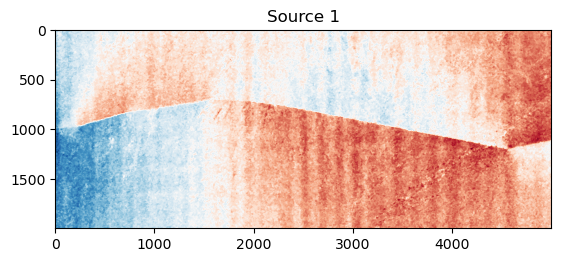

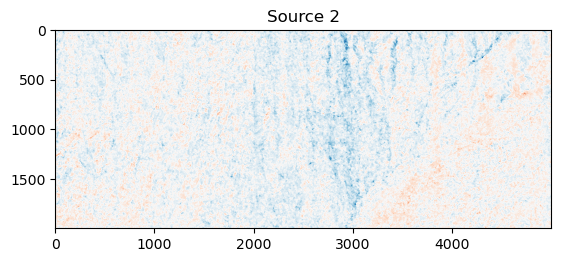

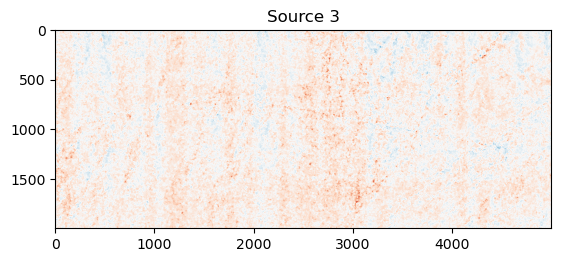

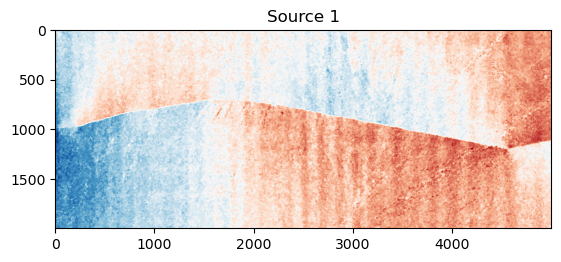

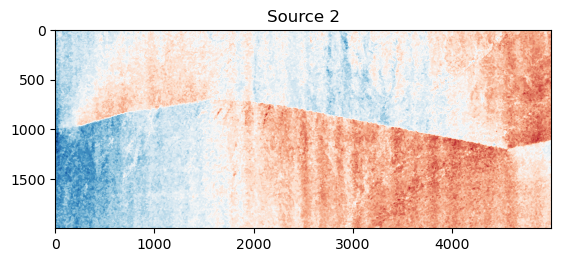

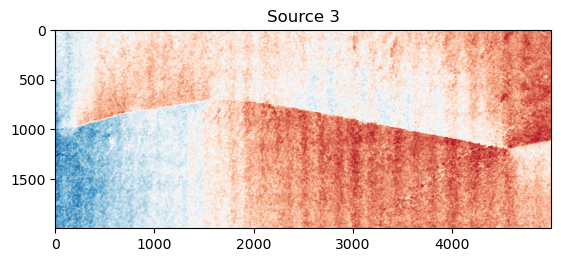

In [21]:
# Apply FastICA
pca = PCA(n_components=3,whiten=True,tol=1e-12)
S_ = pca.fit_transform(im1data_reshaped)  # estimated sources
#A_ = pca.mixing_  # estimated mixing matrix
#print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(shape[0], shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source),vmax = np.max(source))
    plt.title(f'Source {i+1}')
    plt.show()


Estimated mixing matrix:
[[  63.37444531 -633.69959593  -62.95835261 -191.04197457]
 [  66.46389533 -681.62435325   34.74093885  -16.22459595]
 [-116.39031463 -608.39556701   61.88491563 -230.96990974]
 [-143.88746358 -644.44745744  -77.30473339  -66.71733938]]


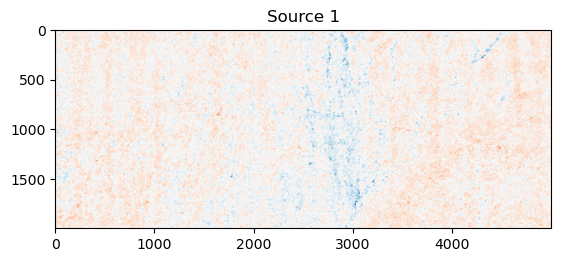

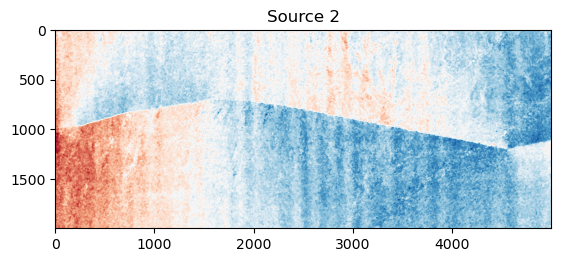

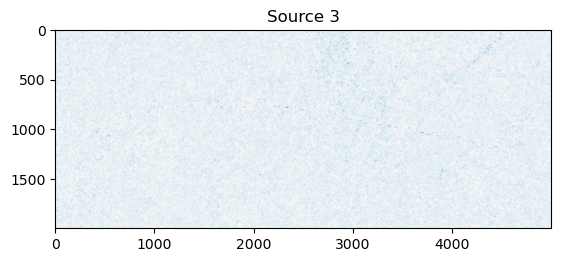

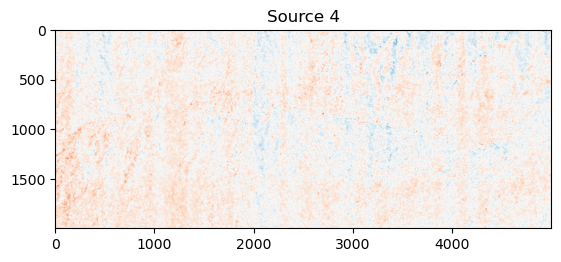

In [24]:
# Apply FastICA
ica = FastICA(n_components=4,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=10000,tol=1e-12)
S_ = ica.fit_transform(im1data_reshaped)  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(shape[0], shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source),vmax = np.max(source))
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Reconstruct S to zero out the noise
denoised = S_[:,(1,2,4)]@A_[:,(1,2,4)].T
noise = S_[:,(0,3)]@A_[:,(0,3)].T
np.shape(denoised), np.shape(noise)

In [ ]:
icaU = denoised[:,8:12].reshape(shape[0],shape[1],4).sum(axis=2)/4
icaE = denoised[:,4:8].reshape(shape[0],shape[1],4).sum(axis=2)/4
icaN = denoised[:,0:4].reshape(shape[0],shape[1],4).sum(axis=2)/4

In [ ]:
n = filt['0'][9000:11000,0:5000]
e = filt['4'][9000:11000,0:5000]
u = filt['8'][9000:11000,0:5000]

In [ ]:
np.sqrt((np.max(n)-np.min(n))**2+(np.max(e)-np.min(n))**2), np.sqrt((np.max(icaN)-np.min(icaN))**2+(np.max(icaE)-np.min(icaE))**2)

In [ ]:
plt.imshow(icaN,vmin=-1,vmax=1)
plt.show()
plt.imshow(filt['0'][9000:11000,0:5000],vmin=-1,vmax=1)


In [ ]:
plt.Figure()
# Recover and visualize the sources
for i in range(denoised.shape[1]):
    source = denoised[:, i].reshape(shape)
    plt.imshow(source, cmap='RdBu',vmin=-1,vmax=1)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:

im1 = gdal.Open(folder+'defaultsMEC1/NSmicmac.tif')
im1data = im1.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im2 = gdal.Open(folder+'defaultsMEC3/NSmicmac.tif')
im2data = im2.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im3 = gdal.Open(folder+'defaultsMEC2/NSmicmac.tif')
im3data = im3.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im4 = gdal.Open(folder+'defaultsMEC4/NSmicmac.tif')
im4data = im4.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
#im5 = gdal.Open(folder+'defaultsMEC4/Correlmicmac.tif')
#im5data = im5.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im6 = gdal.Open(folder+'defaultsMEC1/EWmicmac.tif')
im6data = im6.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im7 = gdal.Open(folder+'defaultsMEC3/EWmicmac.tif')
im7data = im7.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im8 = gdal.Open(folder+'defaultsMEC2/EWmicmac.tif')
im8data = im8.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im9 = gdal.Open(folder+'defaultsMEC4/EWmicmac.tif')
im9data = im9.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
#im10 = gdal.Open(folder+'2020GarlockEastDEM-cropped-f32.tif')
#im10data = im10.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
#im11 = gdal.Open(folder+'VerticalDisp.tif')
#im11data = im11.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im12 = gdal.Open(folder+'defaultsMEC1/UDmicmac.tif')
im12data = im12.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im13 = gdal.Open(folder+'defaultsMEC3/UDmicmac.tif')
im13data = im13.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im14 = gdal.Open(folder+'defaultsMEC2/UDmicmac.tif')
im14data = im14.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]
im15 = gdal.Open(folder+'defaultsMEC4/UDmicmac.tif')
im15data = im15.GetRasterBand(1).ReadAsArray()[9000:11000,0:5000]

In [ ]:
np.array([[1],[1],[1]])

In [ ]:
# Reshape and stack the images
im1data_reshaped = np.column_stack([filt_dict['0'].reshape(-1, 1),
                                    filt_dict['1'].reshape(-1, 1),
                                    filt_dict['2'].reshape(-1, 1),
                                    filt_dict['3'].reshape(-1, 1),
                                    filt_dict['4'].reshape(-1, 1),
                                    filt_dict['5'].reshape(-1, 1),
                                    filt_dict['6'].reshape(-1, 1),
                                    filt_dict['7'].reshape(-1, 1),
                                    filt_dict['8'].reshape(-1, 1),
                                    filt_dict['9'].reshape(-1, 1),
                                    filt_dict['10'].reshape(-1, 1),
                                    filt_dict['11'].reshape(-1, 1)
                                    ])

In [ ]:
pca = PCA(n_components='mle',whiten=True)
pcaFit = pca.fit_transform(im1data_reshaped)

for i in range(S_.shape[1]):
    source = pcaFit[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Apply FastICA
ica = FastICA(n_components=4,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=1000,tol=1e-6)
S_ = ica.fit_transform(im1data_reshaped)  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
np.shape(S_[:,(0,1,2)])

In [ ]:
# Reconstruct S to zero out the noise
denoised = S_[:,(0,1,2)]@A_[:,(0,1,2)].T
noise = S_[:,(3)]@A_[:,(3)].T
np.shape(denoised), np.shape(noise)


In [ ]:
plt.Figure()
# Recover and visualize the sources
for i in range(denoised.shape[1]):
    source = denoised[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
1/1000

In [ ]:
plt.Figure()
# Recover and visualize the sources
for i in range(denoised.shape[1]):
    source = denoised[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
dN = np.sum(denoised[:,0:4],axis=1).reshape(im1data.shape[0], im1data.shape[1])/4
dE = np.sum(denoised[:,4:8],axis=1).reshape(im1data.shape[0], im1data.shape[1])/4
dU = np.sum(denoised[:,8:12],axis=1).reshape(im1data.shape[0], im1data.shape[1])/4
dNoise = np.sum(noise,axis=1).reshape(im1data.shape[0], im1data.shape[1])/4

In [ ]:
plt.imshow(dN)
plt.show()
plt.imshow(dE)
plt.show()
plt.imshow(dU)
plt.show()
plt.imshow(dNoise)

In [ ]:
compare = S_[:, i].reshape(im1data.shape[0], im1data.shape[1][1500,:])
plt.imshow(compare)
plt.show()
plt.imshow(im4data)
plt.show()
#plt.imshow(imYdata)
plt.show()
#plt.plot(pcaFit[:, 0].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='black',linewidth=0.5)
#plt.plot(pcaFit[:, 1].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='red',linewidth=0.5)
#plt.plot(pcaFit[:, 2].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='orange',linewidth=0.5)
plt.plot(compare[:,500])
plt.twinx()
plt.plot(im4data[:,500]-im4data[:,500].mean(),color='black',linewidth=0.5)
plt.plot(imYdata[:,500]-imYdata[:,500].mean(),color='black',linewidth=0.5)

plt.show()

#plt.imshow(imYdata)
plt.show()
#plt.plot(pcaFit[:, 0].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='black',linewidth=0.5)
#plt.plot(pcaFit[:, 1].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='red',linewidth=0.5)
#plt.plot(pcaFit[:, 2].reshape(im1data.shape[0], im1data.shape[1])[:,500],color='orange',linewidth=0.5)
plt.plot(compare[1500,:])
plt.twinx()
plt.plot(im4data[1500,:]-im4data[1500,:].mean(),color='black',linewidth=0.5)
plt.plot(imYdata[1500,:]-imYdata[1500,:].mean(),color='black',linewidth=0.5)

In [ ]:
np.std(compare-imYdata), np.std((im1data+im2data+im3data+im4data)/4-imYdata), np.std(dE-imXdata), np.std((im6data+im7data+im8data+im9data)/4-imXdata)

In [ ]:
# Apply FastICA
ica = FastICA(n_components=3,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=1000,tol=1e-15)
S_ = ica.fit_transform(im1data_reshaped[:,:4])  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
np.max((S_@newA.T)[:,8]), np.max(np.sum((S_@newA.T)/6,axis=1))

In [ ]:
plt.plot(np.sum((S_@newA.T),axis=1).reshape(im1data.shape[0], im1data.shape[1])[1500,:]/6)
plt.twinx()
plt.plot(im6data[1500,:]-im6data[1500,:].mean(),color='black',linewidth=0.5)

In [ ]:
# Apply FastICA
ica = FastICA(n_components=4,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=1000,tol=1e-15)
S_ = ica.fit_transform(im1data_reshaped[:,4:8])  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

plt.plot(source[1500,:],linewidth=0.5)
plt.twinx()
plt.plot(im4data[1500,:],color='black',linewidth=0.5)

In [ ]:
# Apply FastICA
ica = FastICA(n_components=2,fun='logcosh',whiten='arbitrary-variance',whiten_solver='eigh',max_iter=10000,tol=1e-15)
S_ = ica.fit_transform(im1data_reshaped[:,8:12])  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/4,vmax=np.max(source)/4)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/4,vmax=np.max(source)/4)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
# Negentropy function following geoICA approach of Saif Aati 2022
def my_g(x):
    return -np.exp(-x**2/2), (-x*np.exp(-x**2/2)).mean(axis=-1)

x = np.arange(-1,1,0.1)
y, dy = my_g(x)
plt.plot(x,y)


In [ ]:
# Apply FastICA
ica = FastICA(whiten='arbitrary-variance',fun=my_g,whiten_solver='eigh')
S_ = ica.fit_transform(im1data_reshaped)  # estimated sources
A_ = ica.mixing_  # estimated mixing matrix
print("Estimated mixing matrix:\n{}".format(A_))
plt.Figure()
# Recover and visualize the sources
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/2,vmax=np.max(source)/2)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
for i in range(S_.shape[1]):
    source = S_[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu',vmin=np.min(source)/2,vmax=np.max(source)/2)
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
for i in range(0,4):
    print(np.max(S_[:, i].reshape(im1data.shape[0], im1data.shape[1]))-np.min(S_[:, i].reshape(im1data.shape[0], im1data.shape[1])))
    print(np.max(im1data_reshaped[:, i].reshape(im1data.shape[0], im1data.shape[1]))-np.min(im1data_reshaped[:, i].reshape(im1data.shape[0], im1data.shape[1])))

In [ ]:
# Recover and visualize the sources
for i in range(len(im1data_reshaped)):
    source = im1data_reshaped[:, i].reshape(im1data.shape[0], im1data.shape[1])
    plt.imshow(source, cmap='RdBu')
    plt.title(f'Source {i+1}')
    plt.show()

In [ ]:
plt.imshow(im11data,cmap='RdBu')


In [ ]:
# Fourier Transform along the first axis
import math
img = im1data
# Round up the size along this axis to an even number
n = int( math.ceil(img.shape[0] / 2.) * 2 )

# We use rfft since we are processing real values
a = np.fft.rfft(img,n, axis=0)

# Sum power along the second axis
a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=1)/a.shape[1]

# Generate a list of frequencies
f = np.fft.rfftfreq(n)

# Graph it
plt.plot(f[1:],a[1:], label = 'sum of amplitudes over y vs f_x')

# Fourier Transform along the second axis

# Same steps as above
n = int( math.ceil(img.shape[1] / 2.) * 2 )

a = np.fft.rfft(img,n,axis=1)

a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=0)/a.shape[0]

f = np.fft.rfftfreq(n)

plt.plot(f[1:],a[1:],  label ='sum of amplitudes over x vs f_y')

plt.ylabel( 'amplitude' )
plt.xlabel( 'frequency' )
plt.yscale( 'log' )

plt.legend()

plt.savefig( 'test_rfft.png' )
#plt.show()

In [ ]:
original = img_as_float(data.chelsea()[100:250, 50:300])

In [ ]:
np.shape(original)

In [ ]:
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
original = im1data

sigma = 0.12
noisy = original

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

im_bayes = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
)
im_visushrink = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est,
    rescale_sigma=True,
)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.
im_visushrink2 = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est / 2,
    rescale_sigma=True,
)
im_visushrink4 = denoise_wavelet(
    noisy,
    #convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est / 4,
    rescale_sigma=True,
)

# Compute PSNR as an indication of image quality
psnr_noisy = peak_signal_noise_ratio(original, noisy)
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)
psnr_visushrink = peak_signal_noise_ratio(original, im_visushrink)
psnr_visushrink2 = peak_signal_noise_ratio(original, im_visushrink2)
psnr_visushrink4 = peak_signal_noise_ratio(original, im_visushrink4)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title(f'Noisy\nPSNR={psnr_noisy:0.4g}')
ax[0, 1].imshow(im_bayes)
ax[0, 1].axis('off')
ax[0, 1].set_title(f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
ax[0, 2].imshow(im_visushrink)
ax[0, 2].axis('off')
ax[0, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n'
    'PSNR=%0.4g' % psnr_visushrink
)
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')
ax[1, 1].imshow(im_visushrink2)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n'
    'PSNR=%0.4g' % psnr_visushrink2
)
ax[1, 2].imshow(im_visushrink4)
ax[1, 2].axis('off')
ax[1, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n'
    'PSNR=%0.4g' % psnr_visushrink4
)
fig.tight_layout()

plt.show()

In [ ]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')

In [ ]:
from skimage import filters
# Show the original image
plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Apply median filter to remove stripes
# The size of the filter should be chosen based on the stripe width
# Here we use a vertical filter to remove horizontal stripes
median_filtered = filters.median(image, footprint=np.ones((50, 50)))

# Apply Gaussian filter to smooth the image
gaussian_filtered = filters.gaussian(image, sigma=10)

# Show the destriped image
plt.figure(figsize=(10, 10))
plt.title("Destriped Image")
plt.imshow(gaussian_filtered, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from scipy.fftpack import fft2

In [ ]:
filtcol = fft2(image)

plt.imshow(np.abs(filtcol))

In [ ]:
filtcol